In [1]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
from astropy.io import fits
from astropy.wcs import WCS

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs
from desi_lowz_funcs import calc_normalized_dist, save_cutouts
from desi_lowz_funcs import find_objects_nearby, process_img, sdss_rgb
from construct_dwarf_galaxy_catalogs import process_sga_matches
from catalog_paper_plots import make_bar_pie


In [2]:
sample_colors = {"BGS_BRIGHT" : "#882255", "BGS_FAINT": "#CC6677", "LOWZ":"#DDCC77", "ELG": "#88CCEE" }
all_samps = list(sample_colors.keys())
all_samps

['BGS_BRIGHT', 'BGS_FAINT', 'LOWZ', 'ELG']

In [55]:
tot_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_combine_catalog.fits")
iron_cat = Table.read("/pscratch/sd/v/virajvm/trash/zpix_iron_small.fits")

In [3]:
sga_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_sga_matched_dwarfs.fits")

In [150]:
# sga_int = sga_cat[sga_cat["TARGETID"] == 39627757658834718]
sga_int = sga_cat[sga_cat["TARGETID"] == 39628497173349836]

img_path = sga_int["IMAGE_PATH"][0]

ra,dec = sga_int["RA"][0], sga_int["DEC"][0]

In [202]:
# print_radecs(temp[(temp["RCHISQ_R"] > 200) & (temp["Z"] < 0.01)]["RA","DEC"], ra="RA",dec="DEC")

In [203]:
## SOLUTION: ONLY APPLY THESE CLEANING CUT FOR SOURCES WITH FRACFLUX < 0.2!!

In [152]:
os.path.exists(img_path)

True

In [103]:
ra,dec

(204.95220772739452, 31.29365013242897)

In [58]:
import requests
session = requests.Session()

In [59]:
save_cutouts(ra,dec,img_path, session, size = int( sga_int["IMAGE_SIZE_PIX"][0]), timeout=120)

In [7]:
# zpix_iron = fits.open("/global/cfs/cdirs/desi/spectro/redux/iron/zcatalog/v1/zall-pix-iron.fits")[1].data
# # # manually build a structured array with the desired fields
# cols = ["TARGET_RA","TARGET_DEC","SPECTYPE","Z","ZWARN","DELTACHI2","TARGETID","SURVEY","PROGRAM","HEALPIX"]
# zpix_iron_small = np.core.records.fromarrays([zpix_iron[c] for c in cols], names=cols)
# zpix_iron_small = zpix_iron_small[(zpix_iron_small["Z"] < 0.01) & (zpix_iron_small["Z"] > 0.0005)]
# hdu = fits.BinTableHDU(zpix_iron_small)
# # suppose zpix_iron_small is already a Table
# hdu.writeto("/pscratch/sd/v/virajvm/trash/zpix_iron_small.fits", overwrite=True)

In [34]:
img_path = sga_cat[sga_cat["TARGETID"] == 39627757658834718]["IMAGE_PATH"][0]

In [ ]:
sga_cat[sga_cat["LO"]]

In [9]:
temp = sga_cat[(sga_cat["SGA_LOGM_SAGA"] < 8.5) & (sga_cat["Z"] < 0.01)]["RA","DEC"]

In [13]:
# print_radecs(temp,ra="RA",dec="DEC",num=400)

In [11]:
print_radecs?

Signature: print_radecs(object_list, num=100, ra='TARGET_RA', dec='TARGET_DEC')
Docstring: <no docstring>
File:      /global/u1/v/virajvm/DESI2_LOWZ/desi_dwarfs/code/desi_lowz_funcs.py
Type:      function

In [7]:
## make a rgb image and then panels with the spectra??

In [153]:
tgids = [39627672602548466, 39627824100806562, 39627757658834718, 39628507122240641, 39633355515366648, 39628497173349836]

In [154]:
## what is happening to this targetid??

In [155]:
def search_around_radec(tgid, dwarf_cat, catalog,c_ra="ra",c_dec="DEC",search_rad_arc = 60,use_spectype=False):
    # ra_col = "TARGET_RA"
    # dec_col ="TARGET_DEC" 
    ra_col = "RA"
    dec_col ="DEC" 
    center_cat = dwarf_cat[dwarf_cat["TARGETID"] == tgid]
    
    ra,dec,zred = center_cat[ra_col][0], center_cat[dec_col][0], center_cat["Z"][0]
    
    near_cat = find_objects_nearby(catalog, ra,dec,deg_rad = search_rad_arc/3600, ra=c_ra,dec=c_dec)

    #only include galaxies that are at the same redshift!!
    near_cat = near_cat[np.abs(near_cat["Z"] - center_cat["Z"]) < 0.001]

    if use_spectype:
        print("Filtering by SPECTYPE")
        near_cat = near_cat[near_cat["SPECTYPE"] == "GALAXY"]

    print(f"Found {len(near_cat)} nearby sources")
    
    return center_cat, near_cat
    
    

def add_label(ax, x, y, label, position="top", color="red", fontsize=12,offset_size = 5):
    """
    Add a text label near a point (x, y) with flexible positioning.

    Parameters
    ----------
    ax : matplotlib Axes
        The axes to plot on.
    x, y : float
        Coordinates of the point.
    label : str
        Text label.
    position : str
        One of ["top", "bottom", "left", "right", "top-left", "top-right",
                "bottom-left", "bottom-right"].
    color : str
        Text color.
    fontsize : int
        Font size.
    """
    offsets = {
        "top":          (0, offset_size, "center", "bottom"),
        "bottom":       (0, -offset_size, "center", "top"),
        "left":         (-offset_size, 0, "right", "center"),
        "right":        (offset_size, 0, "left", "center"),
        "top-left":     (-offset_size, offset_size, "right", "bottom"),
        "top-right":    (offset_size, offset_size, "left", "bottom"),
        "bottom-left":  (-offset_size, -offset_size, "right", "top"),
        "bottom-right": (offset_size, -offset_size, "left", "top"),
    }
    
    dx, dy, ha, va = offsets.get(position, (offset_size, offset_size, "left", "bottom"))
    ax.text(
        x + dx, y + dy,
        label,
        color=color,
        fontsize=fontsize,
        weight="bold",
        ha=ha, va=va
    )


In [179]:
# tgid_search = tgids[-1]
# center_cat, near_cat = search_around_radec(tgid_search, sga_cat, iron_cat,c_ra="TARGET_RA",c_dec="TARGET_DEC",search_rad_arc = 100,use_spectype=True)

# tgid_search = tgids[2]
# center_cat, near_cat = search_around_radec(tgid_search, sga_cat, iron_cat,c_ra="TARGET_RA",c_dec="TARGET_DEC",search_rad_arc = 120)

tgid_search = tgids[1]
center_cat, near_cat = search_around_radec(tgid_search, tot_cat, iron_cat,c_ra="TARGET_RA",c_dec="TARGET_DEC",search_rad_arc = 120)


Found 5 nearby sources


In [180]:
# center_cat, near_cat = search_around_radec(39627757658834718,iron_cat, iron_cat,c_ra="TARGET_RA",c_dec="TARGET_DEC",search_rad_arc = 120)



In [181]:

img_path = center_cat["IMAGE_PATH"][0]


In [182]:

if tgid_search == tgids[1]:
    img_path = "/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds_cutouts/image_tgid_39627824100806562_ra_186.942_dec_1.601.fits"

In [183]:
img_data = fits.open(img_path)
data_arr = img_data[0].data
invvar_arr = img_data[1].data
mask_arr = img_data[2].data
wcs = WCS(fits.getheader( img_path ))

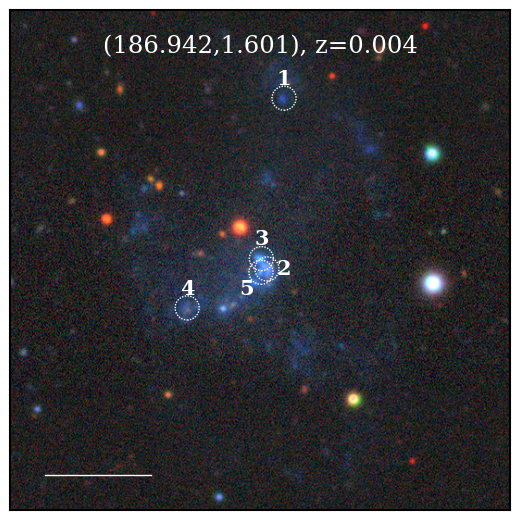

In [188]:
if tgid_search == tgids[2]:
    full_rgb, shift = process_img(data_arr, org_size=np.shape(data_arr)[1], cutout_size=250, return_shift=True)
elif tgid_search == tgids[1]:
    full_rgb, shift = process_img(data_arr, org_size=np.shape(data_arr)[1], cutout_size=540, return_shift=True)
else:
    full_rgb, shift = process_img(data_arr, org_size=np.shape(data_arr)[1], cutout_size=200, return_shift=True)


fig,ax = make_subplots(ncol = 1, nrow = 1,return_fig=True,plot_size=5 )
ax[0].imshow(full_rgb,origin="lower")
for axi in ax:
    axi.set_xticks([])
    axi.set_yticks([])

# plot the 4 DESI spectra for reference :) 
# for si in all_samps:
#     print(si)
#     near_cat_i = near_cat[near_cat["SAMPLE"] == si]
#     if len(near_cat_i) > 0:

all_ras, all_decs = near_cat["TARGET_RA"].data, near_cat["TARGET_DEC"].data
xpixs, ypixs,_ = wcs.all_world2pix(all_ras, all_decs,0,1)

xpts, ypts = xpixs-shift, ypixs-shift

ax[0].scatter(xpts, ypts, edgecolor = "white", s= 300, facecolor = "None",lw=1,ls = ( 0, (1,1) ) )

if tgid_search == tgids[2]:
    off_s = 7.5
    color = "white"
    fs = 15
    add_label(ax[0], xpts[0], ypts[0], "1", position="top", color=color, fontsize=fs,offset_size = off_s)
    add_label(ax[0], xpts[1], ypts[1], "2", position="right", color=color, fontsize=fs,offset_size =off_s)
    add_label(ax[0], xpts[2], ypts[2], "3", position="top", color=color, fontsize=fs,offset_size = off_s)
    add_label(ax[0], xpts[3], ypts[3], "4", position="top", color=color, fontsize=fs,offset_size = off_s)

else:
    off_s = 10
    color = "white"
    fs = 15
    add_label(ax[0], xpts[0], ypts[0], "1", position="top", color=color, fontsize=fs,offset_size = off_s)
    add_label(ax[0], xpts[1], ypts[1], "2", position="right", color=color, fontsize=fs,offset_size =off_s)
    add_label(ax[0], xpts[2], ypts[2], "3", position="top", color=color, fontsize=fs,offset_size = off_s)
    add_label(ax[0], xpts[3], ypts[3], "4", position="top", color=color, fontsize=fs,offset_size = off_s)
    add_label(ax[0], xpts[4], ypts[4], "5", position="bottom-left", color=color, fontsize=fs,offset_size = 7.5)



#add a 15'' bar?
bar_frac = 30/(np.shape(full_rgb)[1] * 0.262 )

# Define bar length in fraction of axes width (e.g., 0.3 = 30% of width)
x_start_frac = 0.07  # 7% from left
y_start_frac = 0.07  # 7% from bottom

# Draw the scale bar in axes coordinates
ax[0].plot([x_start_frac, x_start_frac + bar_frac],
        [y_start_frac, y_start_frac],
        color='white', lw=1, transform=ax[0].transAxes)

ax[0].text(0.5,0.95, f"({center_cat['RA'][0]:.3f},{center_cat['DEC'][0]:.3f}), z={center_cat['Z'][0]:.3f}", transform = ax[0].transAxes, 
           color = "white",fontsize = 17.5, ha="center",va="top")

plt.savefig(f"/pscratch/sd/v/virajvm/trash/dwarf_sparse_ifu_spec/plots/image_{tgid_search:d}.png",bbox_inches="tight")

plt.show()

In [218]:
center_cat

TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,RA,DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FIBERFLUX_R,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MIN_MJD,MAX_MJD,MEAN_MJD,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY,DESINAME,FLUX_G,FLUX_IVAR_G,MAG_G,MAG_G_ERR,FLUX_R,FLUX_IVAR_R,MAG_R,MAG_R_ERR,FLUX_Z,FLUX_IVAR_Z,MAG_Z,MAG_Z_ERR,FIBERMAG_R,OBJID,SIGMA_G,FRACFLUX_G,RCHISQ_G,SIGMA_GOOD_G,SIGMA_R,FRACFLUX_R,RCHISQ_R,SIGMA_GOOD_R,SIGMA_Z,FRACFLUX_Z,RCHISQ_Z,SIGMA_GOOD_Z,SHAPE_R,SHAPE_R_ERR,MU_R,MU_R_ERR,SERSIC,SERSIC_IVAR,BA,TYPE,PHI,NOBS_G,NOBS_R,NOBS_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,LOGM_SAGA,LOGM_M24,SWEEP,is_south,STARFDIST,STARDIST_DEG,STARMAG,STAR_RADIUS_ARCSEC,STAR_RA,STAR_DEC,IMAGE_SIZE_PIX,SAMPLE_DESI,SGA_RA_MOMENT,SGA_DEC_MOMENT,SGA_SMA_SB26,SGA_SMA_SB25,SGA_BA,SGA_PA,SGA_R_COG_MAG,SGA_G_COG_MAG,SGA_Z_COG_MAG,SGA_ZRED_LEDA,SGA_ID,DIST_MPC,OTHER_DIST_MPC,SGA_GR,SGA_LOGM_SAGA,SAMPLE,PCNN_FRAGMENT,IMAGE_PATH,FILE_PATH
,,,,,,,,,,,,,,,,deg,deg,mas / yr,mas / yr,yr,,,,,,,,,,,mag,nanomaggy,,,,mag,mag,mag,mas,,,,,,,,,,,,,,,,,,,,,deg,deg,,s,,,mm,mm,mm,mm,,deg,arcsec,deg,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,nanomaggy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bool,int16,bool,int16,bool,bytes22,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes3,float32,int16,int16,int16,float32,float32,float32,float64,float64,bytes29,int64,float32,float32,float32,float32,float32,float32,int64,bytes10,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64,bytes29,float64,float64,bytes3,float64,bytes117,bytes116
39627757658834718,main,bright,26253,26253,0.006660391095060748,5.141967718794141e-07,0,39581.915350943804,6414.913758424614 .. 220.54986414260736,7889,GALAXY,--,10,82918.83328406338,0,186.5946494639

In [139]:
##get the spectra of these objects!!
import desispec.io
from desispec import coaddition  
import h5py

save_folder_path = "/pscratch/sd/v/virajvm/trash/dwarf_sparse_ifu_spec"

def download_spec_dwarf(near_cat, save_path):


    if os.path.exists(save_path):
        print("File already exists")        

    else:
        data_spec = desispec.io.spectra.read_spectra_parallel(near_cat, nproc=1, prefix='coadd', rdspec_kwargs={ "skip_hdus" : [ "EXP_FIBERMAP", "SCORES", "EXTRA_CATALOG", "MASK", "RESOLUTION"] }, specprod="iron", match_order=True)
        
        #we coadd the spectra!
        spec_combined = coaddition.coadd_cameras(data_spec)
        
        # ##save this now!
        all_fluxs = spec_combined.flux
        all_waves = spec_combined.wave
        all_ivars = spec_combined.ivar
    
        print(all_fluxs["brz"].shape)
        
        all_tgids = near_cat["TARGETID"].data
        all_zreds = near_cat["Z"].data
        
        #then we save this in a hdf5 file!
        
        with h5py.File(save_path, "w") as f:
            f.create_dataset("TARGETID", data=all_tgids, dtype='i8')
            f.create_dataset("Z", data=all_zreds, dtype='f4')
            f.create_dataset("WAVE", data=all_waves["brz"], dtype='f4')  # shared
            f.create_dataset("FLUX", data=all_fluxs["brz"], dtype='f4')
            f.create_dataset("FLUX_IVAR", data=all_ivars["brz"], dtype='f4')
            
        return 
        


In [140]:

download_spec_dwarf(near_cat, f"{save_folder_path}/dataset_{center_cat['TARGETID'][0]:d}.h5")


File already exists


In [179]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator
from astropy.convolution import convolve, Gaussian1DKernel

def make_spectra_panel(center_tgid, wave_min=3400, wave_max = 9800, color = "k",smooth_pix = 2):

    with h5py.File(f"{save_folder_path}/dataset_{center_tgid:d}.h5", "r") as f:
        tgids = f["TARGETID"][:]
        zreds = f["Z"][:]
        fluxs = f["FLUX"][:]
        waves = f["WAVE"][:]
    
    fig, ax = plt.subplots(len(tgids), 1, figsize=(15, 1*int(len(tgids)) ),sharex=True)
    plt.subplots_adjust(hspace = 0.)

    for i in range(len(tgids)):

        print(zreds[i])
    
        waves_rest = waves/(1+zreds[i])

        flux_scale = fluxs[i]/np.median(fluxs[i])

        wave_mask = (waves_rest > wave_min) & (waves_rest < wave_max)

        # raw
        ax[i].plot(waves_rest, flux_scale, color='grey', alpha=0.15, lw=1)

        # smoothed
        flux_smooth = convolve(flux_scale, Gaussian1DKernel(smooth_pix))
        ax[i].plot(waves_rest[5:-5], flux_smooth[5:-5], color=color, lw=1)
        
        ax[i].set_xlim([wave_min, wave_max])
        ax[i].tick_params(axis='both', labelsize=14)

        med = np.median(flux_smooth[wave_mask])
        mad = np.median(np.abs(flux_smooth[wave_mask] - med))

        if i == 2:
            ax[i].set_ylim(med - 25*mad, np.max(flux_smooth) * 1.1)            
        else:
            ax[i].set_ylim(med - 7.5*mad, np.max(flux_smooth) * 1.5)            

        # ax[i].set_ylim([np.min(flux_smooth)  , np.max(flux_smooth) * 1.1])
        # tick_vals = np.linspace(-0.5, np.max(flux_smooth) * 1.125, 3).astype(int)
        ax[i].set_yticks([])

        if i == len(tgids) - 1:
            ax[i].set_xlabel('Rest-Frame Wavelength [$\\AA$]', fontsize=14)


        ax[i].text(0.01,0.875,r"%d"%(i+1),size = 20,transform=ax[i].transAxes, verticalalignment='top',color = "white",bbox=dict(facecolor='k', alpha=1, pad=2) )


        ax[i].text( 0.0975,0.675,f"{tgids[i]:d}",size = 10, transform=ax[i].transAxes,va="center", ha="center")

        #put the number label inside each panel, TARGETID


    plt.savefig(f"/pscratch/sd/v/virajvm/trash/dwarf_sparse_ifu_spec/plots/survey_dwarf_spectra_{center_tgid}.png",bbox_inches="tight",dpi=150)
    plt.show()

    return

    

In [194]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator
from astropy.convolution import convolve, Gaussian1DKernel
import matplotlib.pyplot as plt
import numpy as np
import h5py

def make_spectra_panel_double(center_tgid, wave_min=3400, wave_max=9800, color="k", smooth_pix=2):

    with h5py.File(f"{save_folder_path}/dataset_{center_tgid:d}.h5", "r") as f:
        tgids = f["TARGETID"][:]
        zreds = f["Z"][:]
        fluxs = f["FLUX"][:]
        waves = f["WAVE"][:]
    
    n = len(tgids)

    # pretend we have n+1 rows, but one axis will span 2 rows
    fig = plt.figure(figsize=(15, 1*(n+1)))
    gs = fig.add_gridspec(n+1, 1, hspace=0.0)

    ax_list = []
    for i in range(n):
        if i == 1:
            # make axis spanning 2 rows
            ax = fig.add_subplot(gs[i:i+2, 0], sharex=ax_list[0] if ax_list else None)
        elif i > 1:
            # shift index down by one, since row 1 already taken
            ax = fig.add_subplot(gs[i+1, 0], sharex=ax_list[0])
        else:
            ax = fig.add_subplot(gs[i, 0])
        ax_list.append(ax)

    # now plot into each axis
    for i, ax in enumerate(ax_list):
        waves_rest = waves/(1+zreds[i])
        flux_scale = fluxs[i]/np.median(fluxs[i])

        wave_mask = (waves_rest > wave_min) & (waves_rest < wave_max)

        # raw
        ax.plot(waves_rest, flux_scale, color='grey', alpha=0.15, lw=1)

        # smoothed
        # if smooth_pix == 0:
        if i != 1:
            flux_smooth = convolve(flux_scale, Gaussian1DKernel(smooth_pix))
        else:
            flux_smooth = flux_scale
        # else:
        #     flux_smooth = flux_scale
        ax.plot(waves_rest[5:-5], flux_smooth[5:-5], color=color, lw=1)
        
        ax.set_xlim([wave_min, wave_max])
        ax.tick_params(axis='both', labelsize=14)

        med = np.median(flux_smooth[wave_mask])
        mad = np.median(np.abs(flux_smooth[wave_mask] - med))

        if i == 1:
            ax.set_ylim(med - 100*mad, np.max(flux_smooth[wave_mask]) * 1.1)
        else:
            ax.set_ylim(med - 7.5*mad, np.max(flux_smooth[wave_mask]) * 1.75)

        ax.set_yticks([])

        if i == len(tgids) - 1:
            ax.set_xlabel('Rest-Frame Wavelength [$\\AA$]', fontsize=14)

        ax.text(
            0.01, 0.875, r"%d" % (i+1),
            size=20, transform=ax.transAxes,
            verticalalignment='top', color="white",
            bbox=dict(facecolor='k', alpha=1, pad=2)
        )

        if i == 1:
            ax.text(
                0.0975, 0.77, f"{tgids[i]:d}",
                size=10, transform=ax.transAxes,
                va="center", ha="center"
            )
            
        else:
              ax.text(
            0.0975, 0.675, f"{tgids[i]:d}",
            size=10, transform=ax.transAxes,
            va="center", ha="center"
            )

    plt.savefig(f"/pscratch/sd/v/virajvm/trash/dwarf_sparse_ifu_spec/plots/survey_dwarf_spectra_{center_tgid}.png",bbox_inches="tight",dpi=150)
    plt.show()
    return


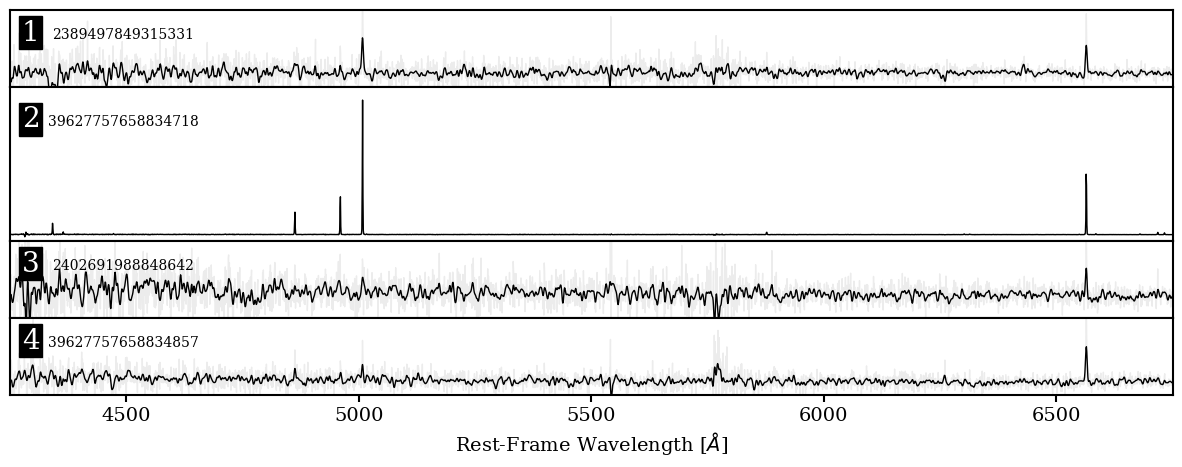

In [195]:

tgid_search = tgids[2]

if tgid_search == tgids[2]:
    make_spectra_panel_double(tgid_search,wave_min=4250, wave_max = 6750, color = "k",smooth_pix=2)
    
if tgid_search == tgids[1]:
    make_spectra_panel(tgid_search,wave_min=4250, wave_max = 6750, color = "k",smooth_pix=2)
